In [1]:
import sys
import config
sys.path.append(config.root)
import glob
from dataloader.read_normalize import read_normalize
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils.imgShow import imgShow
from dataloader.loader import scene_tensor_dset
from dataloader.parallel_loader import threads_scene_dset


In [2]:
paths_as = sorted(glob.glob(config.root+'/data/s1_ascend/*'))
paths_des = sorted(glob.glob(config.root+'/data/s1_descend/*'))
paths_truth = sorted(glob.glob(config.root+'/data/s1_truth/*'))


In [3]:
### -----data read & pre-processing------- ###
scene_list, truth_list = read_normalize(paths_as=paths_as,\
                                    paths_des=paths_des, paths_truth=paths_truth)
len(scene_list)


20

In [4]:
## ------- single thread ------- 
tra_dset_single = scene_tensor_dset(scene_tensor_list=scene_list, \
                truth_tensor_list=truth_list, transforms=config.transforms_tra, scales=[2048,512,256])
print(f'single thread loader: {tra_dset_single.__len__()}')
tra_loader_single = torch.utils.data.DataLoader(tra_dset_single, \
                                                batch_size=4, shuffle=True)


single thread loader: 20


# test full data loader



In [5]:
## ------ multiple threads ------
threads_tra_dset = threads_scene_dset(scene_list[0:15], \
                                    truth_list[0:15], num_thread=20)
print(f'multiple theads loader: {threads_tra_dset.__len__()}')
threads_tra_loader = torch.utils.data.DataLoader(threads_tra_dset, \
                                        batch_size=4, shuffle=True, num_workers=0)


multiple theads loader: 300


In [11]:
for epoch in range(5):
    print(f'epoch {epoch+1}')
    num = 0
    start = time.time()
    # for patch, truth in tra_loader_single:
    for patch, truth in threads_tra_loader:
        num += truth.shape[0]
        # print(num)
    print(f'time/patch:{(time.time()-start)/num},dset size: {num}')
    print(f'time/all_patch:{(time.time()-start)}')


epoch 1
time/patch:0.004601913293202718,dset size: 300
time/all_patch:1.380664587020874
epoch 2
time/patch:0.0045824599266052245,dset size: 300
time/all_patch:1.3748281002044678
epoch 3
time/patch:0.004550440311431885,dset size: 300
time/all_patch:1.365220308303833
epoch 4
time/patch:0.004708650906880696,dset size: 300
time/all_patch:1.4126901626586914
epoch 5
time/patch:0.004587805271148682,dset size: 300
time/all_patch:1.3764467239379883


# Test crop and data augmentation

In [7]:
import torch
from utils.preprocess import crop_scales
from utils.img_aug import rotate, flip, missing, numpy2tensor, torch_noise

def scenes2patches(scene_list, truth_list, scales=[2048, 512, 256]):    
    patch_list, ptruth_list = [],[]
    transforms = [rotate(prob=0.3), flip(prob=0.3), missing(prob=0.2, ratio_max = 0.2), \
                                numpy2tensor(), torch_noise(prob=0.3, std_min=0.001, std_max=0.1)]
     #'''convert image to patches group'''
    zip_data = list(zip(scene_list, truth_list))
    for scene, truth in zip_data:
        start_0 = time.time()
        patches_group, truth = crop_scales(scales=scales, threads=False)(scene, truth)
        start_1 = time.time()
        time_crop = start_1-start_0 
        for transform in transforms:
            patches_group, truth = transform(patches_group, truth)
        time_aug = time.time()-start_1
        print(f'time_crop:{time_crop:.3f}, time_aug:{time_aug:.3f}')  

        truth = torch.unsqueeze(truth,0)
        patch_list.append(patches_group), ptruth_list.append(truth)
    return patch_list, ptruth_list
    
patch_list, ptruth_list = scenes2patches(scene_list, truth_list, scales=[2048, 512, 256])
print(len(patch_list))


time_crop:0.003, time_aug:0.008
time_crop:0.003, time_aug:0.002
time_crop:0.003, time_aug:0.009
time_crop:0.003, time_aug:0.002
time_crop:0.003, time_aug:0.002
time_crop:0.003, time_aug:0.003
time_crop:0.003, time_aug:0.001
time_crop:0.003, time_aug:0.002
time_crop:0.003, time_aug:0.004
time_crop:0.003, time_aug:0.002
time_crop:0.003, time_aug:0.007
time_crop:0.003, time_aug:0.003
time_crop:0.003, time_aug:0.006
time_crop:0.003, time_aug:0.002
time_crop:0.003, time_aug:0.003
time_crop:0.003, time_aug:0.002
time_crop:0.003, time_aug:0.001
time_crop:0.003, time_aug:0.001
time_crop:0.003, time_aug:0.007
time_crop:0.003, time_aug:0.007
20


## 1. test crop/crop_scales

In [8]:
from utils.preprocess import crop_scales, crop
### ----- crop -----
for i in range(5):
    start = time.time()
    patch_high, ptruth_high = crop(scene_list[0], truth_list[0], size=(256, 256))
    print(f'time/patch_group:{time.time()-start}')


time/patch_group:2.6941299438476562e-05
time/patch_group:1.2159347534179688e-05
time/patch_group:7.3909759521484375e-06
time/patch_group:6.9141387939453125e-06
time/patch_group:6.67572021484375e-06


In [9]:
### ----- crop_scales -----
for i in range(5):
    start = time.time()
    patch_group, ptruth = crop_scales(scales=(2048, 512, 256), threads=False)(scene_list[0], truth_list[0])
    print(f'---time/patch_group:{time.time()-start:.4f}')



---time/patch_group:0.0032
---time/patch_group:0.0038
---time/patch_group:0.0029
---time/patch_group:0.0030
---time/patch_group:0.0027


## 1.1 test downsample

In [10]:
patch_high, ptruth_high = crop(scene_list[0], truth_list[0], size=(2048, 2048))
patch_mid, ptruth_mid = crop(scene_list[0], truth_list[0], size=(512, 512))
patch_low, ptruth_low = crop(scene_list[0], truth_list[0], size=(256, 256))
patch_group = [patch_high, patch_mid, patch_low]

In [11]:
import cv2
start = time.time()
patch_group_down = []
start_0 = time.time()
for patch in patch_group[:-1]:
    ## per band downsample faster than multi-band downsample
    start = time.time()
    # patch_down=[cv2.resize(patch[num], dsize=(256, 256), \
                        # interpolation=cv2.INTER_AREA) for num in range(patch.shape[0])]
    patch_down=[cv2.resize(patch[num], dsize=(256, 256), \
                    interpolation=cv2.INTER_LINEAR) for num in range(patch.shape[0])]
    print(time.time()-start)
    patch_group_down.append(np.array(patch_down))
patch_group_down.append(patch_group[-1])

print(f'time/patch:{time.time()-start_0}')


0.0016360282897949219
0.0006327629089355469
time/patch:0.003233671188354492


## 2. test data augmentation


## 2.1 test noisy

time_noisy:0.0051517486572265625


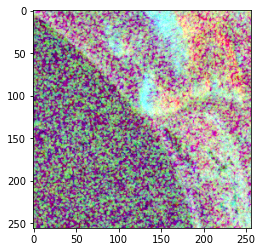

In [13]:
import random
patch_group_down, ptruth=crop_scales(scales=(2048, 512, 256),threads=False)(scene_list[0],truth_list[0])
patch_group_down, ptruth = numpy2tensor()(patch_group_down, ptruth)

start = time.time()
std = random.uniform(0.001, 0.1)
for i in range(len(patch_group_down)):
    # noises = np.random.normal(loc=0, scale=std, size=patch_group_down[i].shape)
    noises = torch.normal(mean=0, std=std, size=(4,256,256))
    patch_noisy = patch_group_down[i]+noises

print(f'time_noisy:{(time.time()-start)}')
# imgShow(patch_noisy.numpy().transpose(1,2,0))


## 2.2 test missing



In [17]:
import random
patch_group_down, ptruth=crop_scales(scales=(2048, 512, 256),threads=False)(scene_list[0],truth_list[0])
start = time.time()
patch_group_down_miss, ptruth_miss = missing(prob=1)(patch_group_down, ptruth)
print(f'time_noisy:{(time.time()-start)}')





time_noisy:0.0008525848388671875
